In [4]:
import cv2
import matplotlib.pyplot as plt
# import things
# Core libraries
import numpy as np
import tensorflow.keras.backend as K
# Patching and reconstruction
from patchify import patchify, unpatchify
# Deep learning framework
from tensorflow.keras.models import load_model


In [5]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
# Load the model you trained in task5_training.ipynb
patch_size = 128
example_file_name = f'unet_model_{patch_size}px.h5'
model = load_model(example_file_name, custom_objects={"f1": f1})

In [7]:
# Load the test image

task5_test_image_path = 'task5_test_image.png'
image = cv2.imread(task5_test_image_path, cv2
                   .IMREAD_COLOR)
image.shape

(3006, 4112, 3)

In [8]:
def process_single_image(image_path, output_size=(1024, 1024)):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding
    _, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Get bounding box coordinates
    x, y, width, height = cv2.boundingRect(largest_contour)

    # Calculate the side length of the square bounding box
    side_length = max(width, height)

    # Calculate the center of the bounding box
    x_center = x + width // 2
    y_center = y + height // 2

    # Calculate the bounding box
    x_start = max(0, x_center - side_length // 2)
    y_start = max(0, y_center - side_length // 2)
    x_end = min(image.shape[1], x_start + side_length)
    y_end = min(image.shape[0], y_start + side_length)

    # Adjust the starting coordinates if the ending coordinates exceed the image dimensions
    x_start = max(0, x_end - side_length)
    y_start = max(0, y_end - side_length)

    # Crop and resize the image
    cropped_image = image[y_start:y_end, x_start:x_end]
    resized_image = cv2.resize(cropped_image, output_size, interpolation=cv2.INTER_AREA)

    return resized_image, (x_start, y_start, side_length)


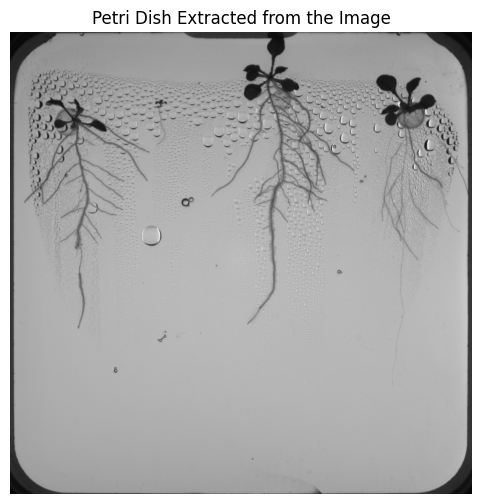

In [9]:
# Preprocess the test image
preprocessed_image, crop_coords = process_single_image(image, output_size=(1024, 1024))

# Visualize the processed image
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2RGB))
plt.title("Petri Dish Extracted from the Image")
plt.axis("off")
plt.show()


In [10]:
patch_size = 128
step = patch_size

# Create patches from the Petri dish ROI
image_patches = patchify(preprocessed_image, (patch_size, patch_size, 3), step)

# Reshape the patches for prediction
reshaped_patches = image_patches.reshape(-1, patch_size, patch_size, 3) / 255.0  # Normalize to [0, 1]

print(f"Patches num: {image_patches.shape[0]}x{image_patches.shape[1]}")
print(f"Reshaped patches: {reshaped_patches.shape}")

Patches num: 8x8
Reshaped patches: (64, 128, 128, 3)


In [11]:
predicted_patches = model.predict(reshaped_patches, batch_size=64, verbose=1)
predicted_patches = predicted_patches.reshape(image_patches.shape[0], image_patches.shape[1], patch_size, patch_size, 1)
print(f"Predicted patches: {predicted_patches.shape}")

1/1 [==============================] - 5s 5s/step
Predicted patches: (8, 8, 128, 128, 1)


In [12]:
# Remove the extra channel dimension for unpatchify
predicted_patches = predicted_patches.squeeze(-1)  # Shape becomes (8, 8, 128, 128)

# Reconstruct the full predicted mask
predicted_mask_padded = unpatchify(predicted_patches, preprocessed_image.shape[:2])

print(f"Reconstructed mask: {predicted_mask_padded.shape}")

Reconstructed mask: (1024, 1024)


In [13]:
# Step 6: Reverse cropping to align with the original image
def reverse_cropping(mask, coords, original_shape):
    x_start, y_start, side_length = coords
    x_end, y_end = x_start + side_length, y_start + side_length

    # Create a blank mask of the original image size
    aligned_mask = np.zeros(original_shape[:2], dtype=mask.dtype)

    # Resize the mask to fit the original cropped area
    resized_mask = cv2.resize(mask, (side_length, side_length), interpolation=cv2.INTER_NEAREST)

    # Place the resized mask back into the corresponding coordinates
    aligned_mask[y_start:y_end, x_start:x_end] = resized_mask

    return aligned_mask


# Align the mask to the original image size
aligned_mask = reverse_cropping(predicted_mask_padded, crop_coords, image.shape)

print(f"Aligned mask: {aligned_mask.shape}")

Aligned mask: (3006, 4112)


In [14]:
# Make sure it's binary
binary_mask = (aligned_mask > 0.5).astype(np.uint8) * 255

print(f"{np.unique(binary_mask)}")


[  0 255]


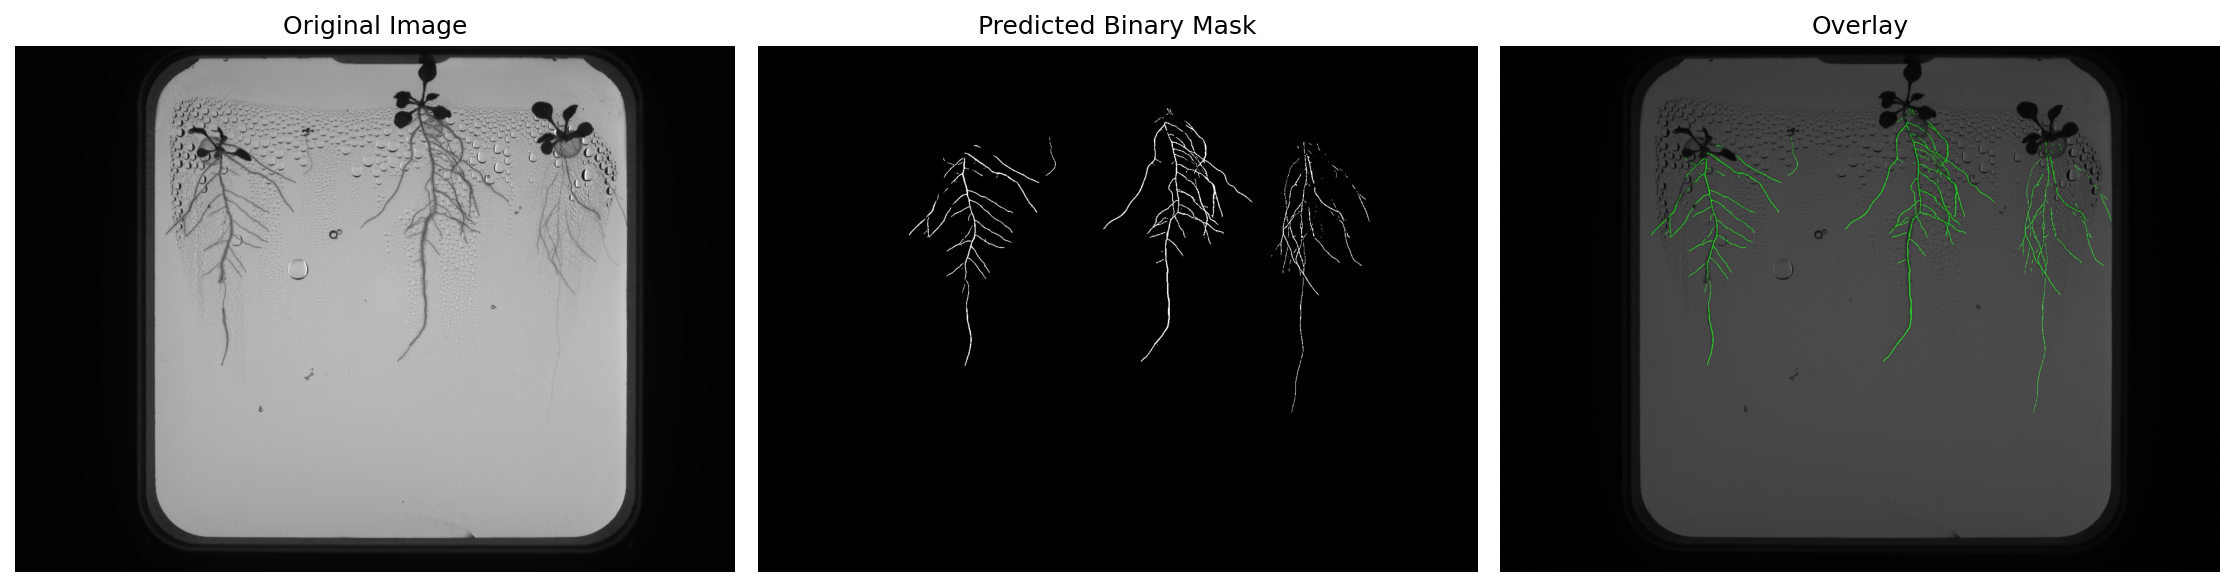

In [15]:
# Create a colored overlay for the binary mask  
overlayed_image = image.copy()
color_of_mask = np.zeros_like(image)
color_of_mask[:, :, 1] = binary_mask

# Combine the original image with the colored mask
alpha = 0.6
overlayed_image = cv2.addWeighted(color_of_mask, alpha, overlayed_image, 1 - alpha, 0)

# Visualize the new overlay
f, ax = plt.subplots(1, 3, dpi=150, figsize=(15, 5))
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original Image')

ax[1].imshow(binary_mask, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Predicted Binary Mask')

ax[2].imshow(overlayed_image)
ax[2].axis('off')
ax[2].set_title('Overlay')
plt.tight_layout()
plt.show()


In [ ]:
# Save the predicted binary mask
output_filename = f"test_image_prediction.png"

cv2.imwrite(output_filename, binary_mask)
print(f"Saved mask as {output_filename}")

cv2.imwrite("test_image_overlay.png", overlayed_image)


Saved mask as task5_test_image_prediction_dominik_231643.png


True